Вот более простой пример использования LIME для классификации изображений с помощью Keras (версия v2 или выше)

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.8.0


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 8.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=a2786072081edfed5928d47653f96079e7ed1411bb6fb0986408811b217f2a2f
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# Используем Inception
Здесь мы создаем стандартную предварительно обученную модель Inception V3 и используем ее на изображениях, предварительно обработав их с помощью инструментов предварительной обработки

In [ ]:
inet_model = inc_net.InceptionV3()

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

## Давайте посмотрим на топ-5 прогнозов для некоторого изображения

49152/35363 [=========================================] - 0s 0us/step
('n02133161', 'American_black_bear', 0.63715905)
('n02105056', 'groenendael', 0.031818114)
('n02104365', 'schipperke', 0.029944422)
('n01883070', 'wombat', 0.028509486)
('n01877812', 'wallaby', 0.025093613)


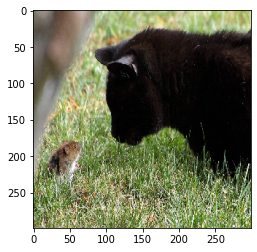

In [ ]:
images = transform_img_fn([os.path.join('data','cat_mouse.jpg')])
# Я делю на 2 и добавляю 0,5 из-за того, что так этот inception представляет изображения
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

## Объяснение
Теперь давайте получим объяснение

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer()

hide_color - это цвет для выключенного суперпикселя. В качестве альтернативы, если оно равно NONE, суперпиксель будет заменен средним значением его пикселей. Здесь мы устанавливаем его равным 0 (в представлении, используемом начальной моделью, 0 означает серый цвет).

In [ ]:
%%time
# hide_color - это цвет для выключенного суперпикселя. В качестве альтернативы, если оно равно NONE, суперпиксель будет заменен средним значением его пикселей. Здесь мы устанавливаем его равным 0 (в представлении, используемом начальной моделью, 0 означает серый цвет).
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 6min 2s, sys: 4.56 s, total: 6min 7s
Wall time: 3min 27s


Классификаторы изображений работают немного медленно.

### Теперь давайте посмотрим объяснение для высшего класса (Черный Медведь)

Мы можем видеть 5 лучших суперпикселей, которые наиболее позитивно относятся к классу, а остальная часть изображения скрыта

In [ ]:
from skimage.segmentation import mark_boundaries

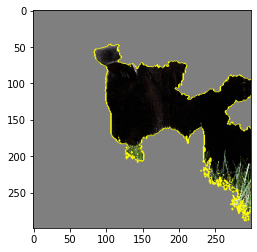

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Или с присутствием остальной части изображения:

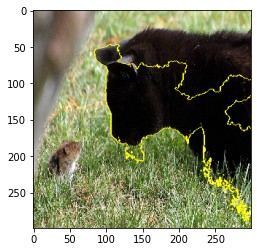

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Мы также можем видеть "плюсы и минусы" (плюсы выделены зеленым цветом, минусы - красным).

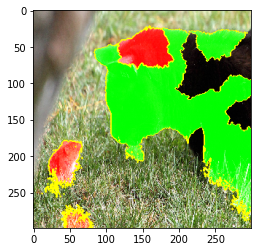

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Или плюсы и минусы, которые имеют вес не менее 0,1

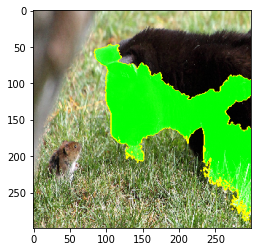

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

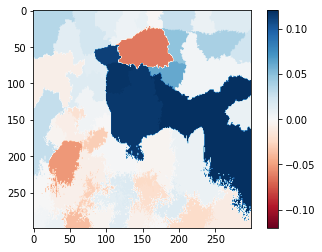

In [ ]:
#Выбери тот же класс, который описан на рисунках выше.
ind =  explanation.top_labels[0]

#Сопоставим каждый вес объяснения с соответствующим суперпикселем
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Показ. Визуализация имеет больше смысла, если используется симметричная цветовая панель.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### Давайте посмотрим на объяснение второго по величине прогноза

Наиболее позитивно относится к вомбату:

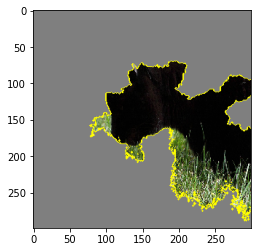

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

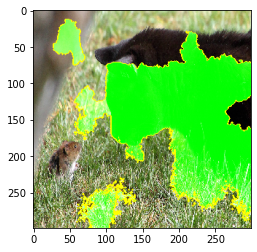

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
